In [4]:
# general imports
! pip install tensorflow numpy tensorflow_privacy  
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# tensorflow imports
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

     -------------------------------------- 455.9/455.9 MB 6.3 MB/s eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 72.6 MB/s eta 0:00:00
     ------------------------------------- 287.4/287.4 KB 17.3 MB/s eta 0:00:00
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ---------------------------------------- 5.9/5.9 MB 75.2 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 104.6 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached wrapt-1.14.1-cp39-cp39-win_amd64.whl (35 kB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 438.7/438.7 KB ? eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ------------------------------

You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
# tensorflow-privacy 
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_privacy\privacy\membership_inference_attack\__init__.py:18: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  warnings.warn(


## Some helper methods

In [6]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (224, 224))
    return image, label

def load_cifar100():
    (train_data, train_labels), (test_data,test_labels) = tf.keras.datasets.cifar10.load_data()                                
    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

    train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
    train_data = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=100, drop_remainder=False))
    test_data = (test_ds
                 .map(process_images)
                 .shuffle(buffer_size=test_ds_size)
                 .batch(batch_size=10, drop_remainder=False))

    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()

    return train_data, train_labels, test_data, test_labels 
  
 
def densenet(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False)    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes)(x) 

    model = Model(inputs=base_model.input, outputs=predictions)   
   
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [11]:
train_data, train_labels, test_data, test_labels = load_cifar100()
img = list(train_data.as_numpy_iterator())
print(train_labels.shape, test_labels.shape)
print(len(img))

(50000,) (10000,)


KeyboardInterrupt: 

KeyboardInterrupt: 

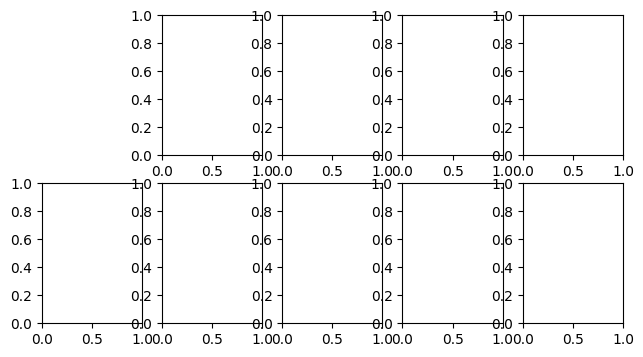

In [12]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(list(train_data.as_numpy_iterator())[i])

plt.tight_layout()
plt.show()

In [10]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [11]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training
Train the model for 30 epochs. 

The idea is that we can use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk respectively. 


In [12]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=30)

Epoch 1/30
391/391 [==============================] - 14s 13ms/step - loss: 1.6588 - accuracy: 0.3896 - val_loss: 1.4134 - val_accuracy: 0.4852
Epoch 2/30
391/391 [==============================] - 5s 12ms/step - loss: 1.3149 - accuracy: 0.5270 - val_loss: 1.2858 - val_accuracy: 0.5464
Epoch 3/30
391/391 [==============================] - 5s 12ms/step - loss: 1.1779 - accuracy: 0.5825 - val_loss: 1.1221 - val_accuracy: 0.6070
Epoch 4/30
391/391 [==============================] - 5s 12ms/step - loss: 1.0721 - accuracy: 0.6202 - val_loss: 1.0901 - val_accuracy: 0.6144
Epoch 5/30
391/391 [==============================] - 5s 13ms/step - loss: 0.9879 - accuracy: 0.6532 - val_loss: 1.0055 - val_accuracy: 0.6517
Epoch 6/30
391/391 [==============================] - 5s 12ms/step - loss: 0.9291 - accuracy: 0.6736 - val_loss: 0.9920 - val_accuracy: 0.6530
Epoch 7/30
391/391 [==============================] - 4s 11ms/step - loss: 0.8697 - accuracy: 0.6956 - val_loss: 0.9960 - val_accuracy: 0.648

(0.0, 1.0)

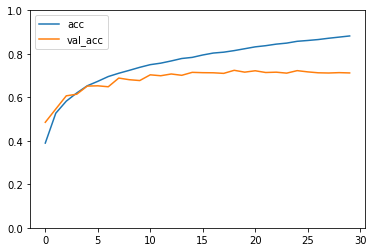

In [13]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

### Attack on the model

In [26]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = tf.nn.softmax(logits_train, axis=-1)
prob_test = tf.nn.softmax(logits_test)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...


In [33]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [34]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [35]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [38]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [39]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2878 training and 2878 test examples) achieved an AUC of 0.71 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 2878 training and 2878 test examples) achieved an advantage of 0.35 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.61
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.60
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.60
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an advantage of 

Figure(432x288)


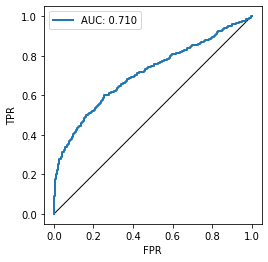

In [41]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))